# MScausality User Manual

This notebook reviews the main functions and workflow in MScausality.

MScausality is designed to perform causal inference on Mass Spectrometry 
(MS)-based proteomics experiments. The goal is to predict the effect of 
interventions (e.g., inhibition) on the biological system.

## General imports

In [59]:
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline

## Input data

`MScausality` takes as input the output of the `MSstats` `dataProcess` function.
The `dataProcess` function outputs a list of mutitple `data.frame`. 
Specifically, MScausality takes as input the `ProteinLevelData` `data.frame` 
output of `dataProcess`. The `ProteinLevelData` is the summarized protein-level 
data, which includes one value per protein per MS run. This is contrast to 
the actual output of MS-based experiments (generally either the precursor or 
fragment, depending on the acquisition method / MS1 vs MS2 quantification).

`MSstats` is an R package which can be used to process identified and 
quantified MS-based proteomics data. Eventually the goal would be to call this 
function directly from `MScausality`. For now, you can find R code to run this 
function in the notes of the `MScausality.data_analysis.dataProcess` function.

In this example we will use the small molecule inhibition dataset from Talus 
Bio.

In [78]:
input_data = pd.read_csv("../data/Talus/processed_data/ProteinLevelData.csv")
input_data.head()

,RUN,Protein,LogIntensities,originalRUN,GROUP,SUBJECT,TotalGroupMeasurements,NumMeasuredFeature,MissingPercentage,more50missing,NumImputedFeature
0,1,1433B_HUMAN,12.873423,230719_THP-1_Chrom_end2end_Plate1_DMSO_A02_DIA,DMSO,2,1210,10,0.0,False,0
1,2,1433B_HUMAN,12.866217,230719_THP-1_Chrom_end2end_Plate1_DMSO_A05_DIA,DMSO,5,1210,10,0.0,False,0
2,3,1433B_HUMAN,12.686827,230719_THP-1_Chrom_end2end_Plate1_DMSO_A10_DIA,DMSO,10,1210,10,0.0,False,0
3,4,1433B_HUMAN,12.625462,230719_THP-1_Chrom_end2end_Plate1_DMSO_A12_DIA,DMSO,12,1210,10,0.0,False,0
4,5,1433B_HUMAN,12.538365,230719_THP-1_Chrom_end2end_Plate1_DMSO_B01_DIA,DMSO,13,1210,10,0.0,False,0


## Data pre-processing

`MSstats` will already take care of most data processing for us, however the 
output of the function is the log normalized intensities. The scale of these 
could be an issue. To alleviate this we can just zero center the values using 
the `normalize` function.

In [79]:
import MScausality.data_analysis.normalization as norm

normalized_input_data = norm.normalize(input_data)
normalized_input_data.head()

,RUN,Protein,LogIntensities,originalRUN,GROUP,SUBJECT,TotalGroupMeasurements,NumMeasuredFeature,MissingPercentage,more50missing,NumImputedFeature
0,1,1433B_HUMAN,0.792096,230719_THP-1_Chrom_end2end_Plate1_DMSO_A02_DIA,DMSO,2,1210,10,0.0,False,0
1,2,1433B_HUMAN,0.788732,230719_THP-1_Chrom_end2end_Plate1_DMSO_A05_DIA,DMSO,5,1210,10,0.0,False,0
2,3,1433B_HUMAN,0.704988,230719_THP-1_Chrom_end2end_Plate1_DMSO_A10_DIA,DMSO,10,1210,10,0.0,False,0
3,4,1433B_HUMAN,0.676341,230719_THP-1_Chrom_end2end_Plate1_DMSO_A12_DIA,DMSO,12,1210,10,0.0,False,0
4,5,1433B_HUMAN,0.635681,230719_THP-1_Chrom_end2end_Plate1_DMSO_B01_DIA,DMSO,13,1210,10,0.0,False,0


The last step of data processing is to convert the data into wide format. This 
is the expected input for the causal inference model.

In [80]:
import MScausality.data_analysis.gene_set as gs # TODO: This function should be moved to the data_analysis module

input_data_wide = gs.prep_msstats_data(normalized_input_data, 
                                  gene_map=None, 
                                  parse_gene=True)

# TODO: This should be fixed in the prep_msstats_data function
input_data_wide = input_data_wide.reset_index(drop=True)
input_data_wide.columns.name = None

input_data_wide.head()

,1433E,1433F,1433G,1433S,1433T,1433Z,2A5A,2A5D,2A5E,2A5G,...,ZO2,ZRAB2,ZSC25,ZSC26,ZSWM3,ZW10,ZXDA,ZY11B,ZYX,ZZZ3
0,0.225840,0.123832,0.589143,1.454128,-0.117525,0.953268,-1.281656,-0.547432,-0.921293,-0.740710,...,-0.341784,1.317510,-1.112345,-0.581991,-0.579682,-0.541618,-0.297365,-3.003297,-0.473380,-0.362757
1,0.216403,-0.011802,0.684286,NaN,-0.000762,0.922623,-1.255499,-0.559918,-0.988240,-1.041011,...,-0.534192,1.404333,-1.079364,-0.522598,NaN,-0.512072,-0.305933,-2.146645,-0.496192,-0.078361
2,0.196965,-0.024698,0.595309,NaN,0.092351,0.911097,-1.320579,-0.482999,-0.900310,-0.675478,...,-0.563943,1.284701,-1.153959,-0.444728,-0.105239,-0.679026,-0.161474,-1.115525,-0.454821,-0.103958
3,0.151198,-0.012195,0.650930,1.316495,-0.097062,0.884626,-1.101469,-0.548033,-0.820882,-0.852018,...,-0.631324,1.316418,-0.917394,-1.036883,-0.188491,-0.926527,-0.245087,-1.064517,-0.338689,-0.144062
4,0.110366,-0.178948,0.634346,NaN,-0.116160,0.905834,-1.176373,-0.440045,-0.923341,-0.992772,...,-0.485910,1.383967,-1.024495,-0.447841,-0.260912,-0.749432,-0.044993,-0.878121,-0.571638,-0.160143


## Gene set correlation analysis

A user may be interested in performing a correlation analysis as part of the 
analysis pipeline. This is particularly helpful when trying to determine 
what gene sets might be of interest to build a network around. `MScausality` 
includes a function to determine all pairwise correlations between proteins 
in the dataset.

In [46]:
import MScausality.data_analysis.gene_set as gs # TODO: This function should be moved to the data_analysis module

corr_data = gs.gen_correlation_matrix(input_data_wide, methods=["pearson"], abs_corr=True)

Correlation matrix for pearson:


In [47]:
corr_data["pearson"].head()

,value,index
1,0.238666,"(1433E, 1433F)"
2,0.576070,"(1433E, 1433G)"
3,0.355128,"(1433E, 1433S)"
4,0.510044,"(1433E, 1433T)"
5,0.523771,"(1433E, 1433Z)"


## Gene set analysis

`MScausality` includes functionality for gene set analysis, in case a user 
wants to analyze specific pathways of interest.

This function takes as input a list of gene sets from MSigDB. It looks at how 
many of the proteins in each gene set are highly correlated.

Additionally, the function can see how many differentially abundant proteins are
in the gene set, if differential analysis results are provided (optional).

In [16]:
import MScausality.data_analysis.gene_set as gs

regulatory_paths = gs.test_gene_sets(corr_data, # Correlation data
                                     input_data.columns.values, # All protein names
                                     "../data/gene_sets/test_pathways.json", # MSigDB gene sets
                                     threshold=0.33)# Threshold for correlation

AAANWWTGC_UNKNOWN
AP2_Q6
AP2GAMMA_01
ARHGAP35_TARGET_GENES
ARID3B_TARGET_GENES
CATTGTYY_SOX9_B1
CAVIN1_TARGET_GENES
CBX5_TARGET_GENES
CETS1P54_01
CRGAARNNNNCGA_UNKNOWN
CRX_Q4
E2F1_Q6
E2F1_Q6_01
EN1_01
EPC1_TARGET_GENES
FOXO1_01
FOXO1_02
GCM_Q2
GCNF_01
H1_6_TARGET_GENES
HAND1_TARGET_GENES
HNF4_01_B
HNF4_DR1_Q3
ILK_TARGET_GENES
INSM2_TARGET_GENES
LMO2COM_02
LMTK3_TARGET_GENES
MIF1_01
MMEF2_Q6
NEUROD2_TARGET_GENES
NEUROG3_TARGET_GENES
NPAT_TARGET_GENES
NPM1_TARGET_GENES
PAX3_01
PAX3_B
POU6F1_01
PPAR_DR1_Q2
RFX1_02
RFX7_TARGET_GENES
SEF1_C
SETBP1_TARGET_GENES
SP1_Q4_01
SP1_Q6
STN1_TARGET_GENES
STTTCRNTTT_IRF_Q6
TDRD3_TARGET_GENES
TEAD2_TARGET_GENES
TMTCGCGANR_UNKNOWN
TNCATNTCCYR_UNKNOWN
WRNIP1_TARGET_GENES
WTGAAAT_UNKNOWN
ZBTB12_TARGET_GENES
ZBTB18_TARGET_GENES
ZNF175_TARGET_GENES
ZNF184_TARGET_GENES
ZNF711_TARGET_GENES


,pathway,correlation,total_genes,measured_genes,percent_measured,total_tests,sig_corrs,percent,freq_node_percent,differential_percent
0,AAANWWTGC_UNKNOWN,pearson,195,32,0.164103,496,112,0.225806,0.466667,NaN
1,AP2_Q6,pearson,259,56,0.216216,1540,305,0.198052,0.509804,NaN
2,AP2GAMMA_01,pearson,252,45,0.178571,990,117,0.118182,0.371429,NaN
3,ARHGAP35_TARGET_GENES,pearson,120,17,0.141667,136,50,0.367647,0.400000,NaN
4,ARID3B_TARGET_GENES,pearson,196,20,0.102041,190,17,0.089474,0.333333,NaN
5,CATTGTYY_SOX9_B1,pearson,368,62,0.168478,1891,274,0.144897,0.438596,NaN
6,CAVIN1_TARGET_GENES,pearson,92,18,0.195652,153,19,0.124183,0.400000,NaN
7,CBX5_TARGET_GENES,pearson,883,107,0.121178,5671,850,0.149885,0.505051,NaN
8,CETS1P54_01,pearson,266,58,0.218045,1653,333,0.201452,0.403846,NaN
9,CRGAARNNNNCGA_UNKNOWN,pearson,48,13,0.270833,78,16,0.205128,0.545455,NaN


In [21]:
regulatory_paths.head()

,pathway,correlation,total_genes,measured_genes,percent_measured,total_tests,sig_corrs,percent,freq_node_percent,differential_percent
0,AAANWWTGC_UNKNOWN,pearson,195,32,0.164103,496,112,0.225806,0.466667,NaN
1,AP2_Q6,pearson,259,56,0.216216,1540,305,0.198052,0.509804,NaN
2,AP2GAMMA_01,pearson,252,45,0.178571,990,117,0.118182,0.371429,NaN
3,ARHGAP35_TARGET_GENES,pearson,120,17,0.141667,136,50,0.367647,0.400000,NaN
4,ARID3B_TARGET_GENES,pearson,196,20,0.102041,190,17,0.089474,0.333333,NaN


When we find a gene set of interest, we can extract the genes in the pathway 
using the `extract_genes_in_path` function.

In [85]:
example_pathway = gs.extract_genes_in_path(
    input_data_wide.columns, # All protein names
    "ARHGAP35_TARGET_GENES", # Pathway name of interest
    "../data/gene_sets/test_pathways.json", # MSigDB gene sets
    return_all=False) # Return all genes in the pathway or only measured proteins

example_pathway

['CUL3',
 'ARF3',
 'PLEC',
 'SEC63',
 'TTI2',
 'SEC62',
 'NOP14',
 'BAZ2B',
 'CDK12',
 'DENR',
 'DBR1',
 'TAOK1',
 'UHRF2',
 'PRDX1',
 'RBM39',
 'CBX3',
 'PURA']

Alternatively, we could look for gene sets which include specific genes of 
interest. This is done with the `find_sets_with_gene` function.

In [86]:
reg_sets = gs.find_sets_with_gene(["BRD2"], 
                                  "../data/gene_sets/test_pathways.json")
reg_sets

['TEAD2_TARGET_GENES', 'ZNF175_TARGET_GENES', 'ZNF711_TARGET_GENES']

## Pull network from INDRA

In this section we will pull a network from the biological knowledge database 
INDRA. In order for this to work you must have a `.env` file located in the root
of the `MScausality` with the URL and login information stored. Additionally, 
you must be on Northeastern University's IP address. In the future this needs to
be changed for external users.

The first step is to build a the Neo4jClient using the information in the `.env`
file.

In [38]:
from indra_cogex.client import Neo4jClient # TODO: Move this to the analysis_uniprot function

client = Neo4jClient(url=os.getenv("API_URL"), 
                        auth=(os.getenv("USER"), 
                            os.getenv("PASSWORD"))
                    )

Now we can pull a network using the `analysis_uniprot` function. 

**Note**: Right now this function is a bit of a mess and relies on an edited 
version of `indra_cogex`. I am working to move the edited versions into 
`MScausality`. 

In [39]:
from MScausality.graph_construction.indra_networks import analysis_uniprot

set_name = "ARHGAP35_TARGET_GENES"
indra_network = analysis_uniprot(
    ids=example_pathway,
    analysis_id=set_name,
    client=client,
    minimum_evidence_count=1,
    id_type="gene"
)

/Users/kohler.d/opt/anaconda3/envs/MScausality/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/kohler.d/opt/anaconda3/envs/MScausality/lib/python3.11/site-packages/pydantic/_internal/_config.py:321: UserWarning: Valid config keys have changed in V2:
* 'underscore_attrs_are_private' has been removed
  warnings.warn(message, UserWarning)


26
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
0.00016498565673828125
0
MATCH p=(n1:BioEntity)<-[r1:indra_rel]-(n3:BioEntity)-[r2:indra_rel]->(n2:BioEntity)
WHERE
    n1.id IN ['hgnc:12557', 'hgnc:15923', 'hgnc:654', 'hgnc:26262', 'hgnc:11846', 'hgnc:21082', 'hgnc:24224', 'hgnc:16821', 'hgnc:29259', 'hgnc:9352', 'hgnc:9069', 'hgnc:9701', 'hgnc:15594', 'hgnc:2553', 'hgnc:963', 'hgnc:2769', 'hgnc:1553']
    AND n2.id IN ['hgnc:12557', 'hgnc:15923', 'hgnc:654', 'hgnc:26262', 'hgnc:11846', 'hgnc:21082', 'hgnc:24224', 'hgnc:16821', 'hgnc:29259', 'hgnc:9352', 'hgnc:9069', 'hgnc:9701', 'hgnc:15594', 'hgnc:2553', 'hgnc:963', 'hgnc:2769', 'hgnc:1553']
    AND n1.id <> n2.id
    AND NOT n3.id IN ['hgnc:12557', 'hgnc:15923', 'hgnc:654', 'hgnc:26262', 'hgnc:11846', 'hgnc:21082', 'hgnc:24224', 'hgnc:16821', 'hgnc:29259', 'hgnc:9352', 'hgnc:9069', 'hgnc:9701', 'hgnc:15594', 'hgnc:2553', 'hgnc:963', 'hgnc:2769', 'hgnc:1553']
    AND n3.type = "human_gene_protein"
    AND r1.st

In [41]:
indra_network.head()

,source_hgnc_id,source_hgnc_symbol,relation,target_hgnc_id,target_hgnc_symbol,stmt_hash,evidence_count,source_counts,reason_added,source_observed,target_observed
0,6551,LEF1,DecreaseAmount,9701,PURA,-35492096618959463,2,"{""biopax"": 2}",confounder,False,True
1,6551,LEF1,DecreaseAmount,9069,PLEC,-16067882285354926,2,"{""biopax"": 2}",confounder,False,True
2,644,AR,DecreaseAmount,9701,PURA,2813950575753822,2,"{""biopax"": 2}",confounder,False,True
3,5021,FOXA1,DecreaseAmount,9701,PURA,33746068370996694,3,"{""biopax"": 3}",confounder,False,True
4,5021,FOXA1,DecreaseAmount,12557,UHRF2,7831854607051975,2,"{""biopax"": 2}",confounder,False,True


## Construct latent variable network

The graph extracted from INDRA will inherently be messy and unusable for classic
causal inference. In this section we use the `GraphBuilder` object to convert 
the INDRA statements into a LVM which can be used for causal inference.

Preparing experimental data...
Preparing INDRA statements...
Building graph...
Fixing cycles...


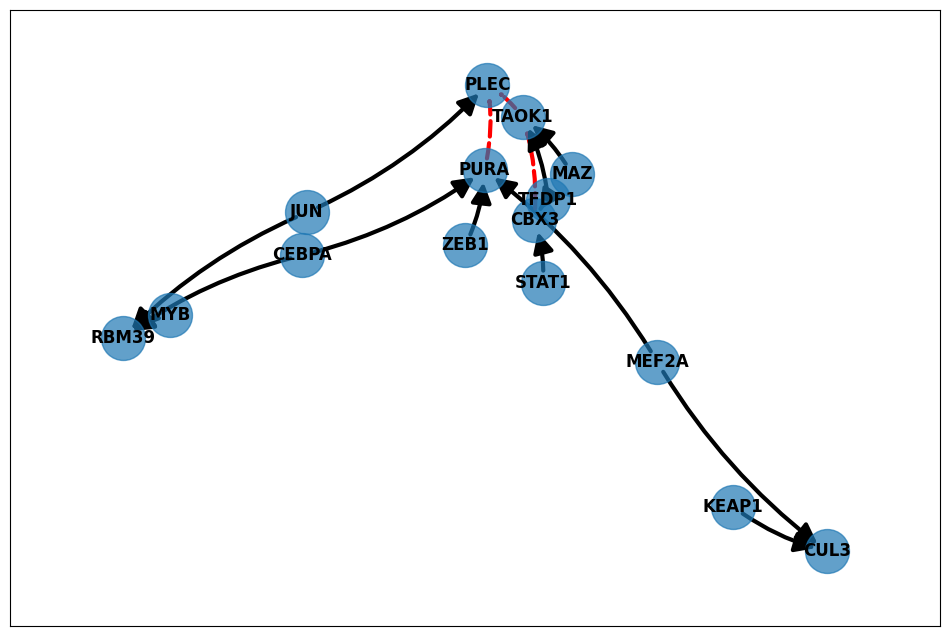

In [50]:
from MScausality.graph_construction.graph import GraphBuilder

example_graph = GraphBuilder(indra_network, 
                                normalized_input_data, 
                                True) # MSstats format or not

example_graph.build_full_graph(data_type="LF", # LF (label free) or TMT
                        protein_format="Gene_Name_Organism", # How the proteins are named in the data
                        source_name="source_hgnc_symbol",
                        target_name="target_hgnc_symbol")
example_graph.build_dag() # TODO: Right now removing cycles can take forever on long graphs. Need a better optimized algo for this.
example_graph.create_latent_graph()
example_graph.plot_latent_graph(figure_size=(12, 8))

## Fit LVM

Now we have a graph and data. We are ready to do some causal inference.

In [51]:
from MScausality.causal_model.LVM import LVM
import pyro

pyro.clear_param_store() # In case you want to run multiple models
lvm = LVM(example_graph.experimental_data.reset_index(drop=True), # Data is already in graph object
          example_graph.causal_graph)
lvm.prepare_graph()
lvm.prepare_data()

lvm.fit_model(num_steps=5000) # Num steps doesn't matter, will be stopped by convergence

Step 0: Loss = 11949.617980982177
Step 100: Loss = -1540.9732158482075
Step 200: Loss = -5674.17950001359
Step 300: Loss = -7475.702118545771
Step 400: Loss = -8458.472659140825
Step 500: Loss = -9249.667808949947
Step 600: Loss = -9758.321359157562
Step 700: Loss = -10069.152234584093
Step 800: Loss = -10516.667860627174
Step 900: Loss = -10765.370442509651
Step 1000: Loss = -10946.888435870409
Step 1100: Loss = -11128.01171413064
Step 1200: Loss = -11370.802011877298
Step 1300: Loss = -11569.704123854637
Stopping early at step 1368 with loss -11684.89211910963


With the trained model we can now perform an intervention.

In [73]:
lvm.intervention({"KEAP1": -5}, "CUL3")
int1 = lvm.intervention_samples
int2 = lvm.posterior_samples

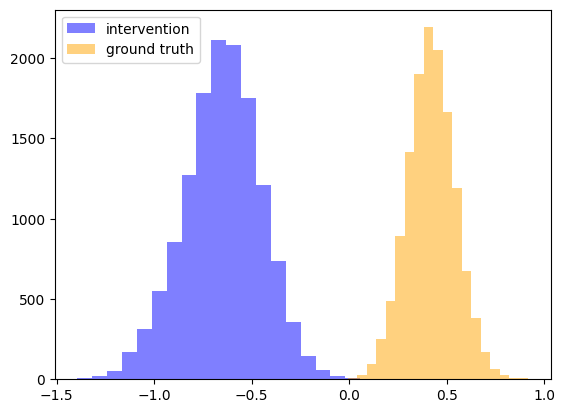

In [77]:
fig, ax = plt.subplots()

ax.hist(int1, alpha=.5, color="blue", bins=20, label="intervention")
ax.hist(int2, alpha=.5, color="orange", bins=20, label="ground truth")
plt.legend()